In [2]:
import sys
sys.path.append('../dataset/')
sys.path.append('../network/')
sys.path.append('../model/')

import os
import glob
import time
import torch
import logging
import argparse
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn as nn
import torch
import seaborn as sns

from pathlib import Path
from main_loading import *
from main_network import *
from main_model_rec import *
from main_model_one_class import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

> Modified things in local:
- Changed the `network/main_network.py`, add a new term rep_dim and changed them all to 2.

# 0. Variable Definitions

In [7]:
label_dict ={0: 'tshirt', 
                1: 'trouser', 
                2: 'pullover', 
                3: 'dress', 
                4: 'coat',
                5: 'sandal', 
                6: 'shirt', 
                7: 'sneaker', 
                8: 'bag', 
                9: 'boot'}

In [8]:
# For data
root = '/net/leksai/data/FashionMNIST'
loader_name = 'fmnist'
loader_eval_name = 'fmnist_eval'
label_normal = (0,)
label_abnormal = (7,)
ratio_abnormal = 0.1

# For model
net_name = 'fmnist_LeNet_rec'
optimizer_ = 'rec'
eta = 0.1
optimizer_name = 'adam'
lr = 0.0001
ae_lr = 0.001
n_epochs = 150
ae_n_epochs = 150
lr_milestones = (50, 100, 150)
batch_size = 128
weight_decay = 0.5e-6
ae_weight_decay = 0.5e-3
device_no = 3
device = 'cuda:3'
n_jobs_dataloader = 0
save_ae = True
load_ae = False
log_path = 'misc/rec_fmnist_0_7.log'
model_path = 'misc/rec_fmnist_0_7.tar'

In [9]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler = logging.FileHandler(log_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# 1. Load Dataset

In [10]:
dataset = load_dataset(loader_name=loader_name,
                       root=root,
                       label_normal=label_normal,
                       label_abnormal=label_abnormal,
                       ratio_abnormal=ratio_abnormal)

Loading dataset for you!
Almost loaded!


# 2. Load Model

In [11]:
model = RecModel(optimizer_, eta)
model.set_network(net_name)

In [12]:
model.train(dataset, eta, optimizer_name, lr, n_epochs, lr_milestones,
            batch_size, weight_decay, device, n_jobs_dataloader, label_normal)

INFO:root:Hey I am loading net for you!
INFO:root:Setting hyper-parameters!
INFO:root:Starting training...


Learning rate: 0.0001


INFO:root:| Epoch: 001/150 | Train Time: 1.123s | Train Loss: 0.100066 |
INFO:root:| Epoch: 002/150 | Train Time: 1.099s | Train Loss: 0.052673 |
INFO:root:| Epoch: 003/150 | Train Time: 1.153s | Train Loss: 0.045484 |
INFO:root:| Epoch: 004/150 | Train Time: 1.081s | Train Loss: 0.042460 |
INFO:root:| Epoch: 005/150 | Train Time: 1.099s | Train Loss: 0.040757 |
INFO:root:| Epoch: 006/150 | Train Time: 1.124s | Train Loss: 0.039611 |
INFO:root:| Epoch: 007/150 | Train Time: 1.155s | Train Loss: 0.038364 |
INFO:root:| Epoch: 008/150 | Train Time: 1.166s | Train Loss: 0.037613 |
INFO:root:| Epoch: 009/150 | Train Time: 1.126s | Train Loss: 0.037107 |
INFO:root:| Epoch: 010/150 | Train Time: 1.063s | Train Loss: 0.036635 |
INFO:root:| Epoch: 011/150 | Train Time: 1.056s | Train Loss: 0.036747 |
INFO:root:| Epoch: 012/150 | Train Time: 1.094s | Train Loss: 0.036013 |
INFO:root:| Epoch: 013/150 | Train Time: 1.140s | Train Loss: 0.035513 |
INFO:root:| Epoch: 014/150 | Train Time: 1.190s | T

INFO:root:| Epoch: 112/150 | Train Time: 1.207s | Train Loss: 0.032308 |
INFO:root:| Epoch: 113/150 | Train Time: 1.158s | Train Loss: 0.032476 |
INFO:root:| Epoch: 114/150 | Train Time: 1.188s | Train Loss: 0.032482 |
INFO:root:| Epoch: 115/150 | Train Time: 1.260s | Train Loss: 0.032391 |
INFO:root:| Epoch: 116/150 | Train Time: 1.151s | Train Loss: 0.032410 |
INFO:root:| Epoch: 117/150 | Train Time: 1.160s | Train Loss: 0.032429 |
INFO:root:| Epoch: 118/150 | Train Time: 1.229s | Train Loss: 0.032416 |
INFO:root:| Epoch: 119/150 | Train Time: 1.285s | Train Loss: 0.032323 |
INFO:root:| Epoch: 120/150 | Train Time: 1.153s | Train Loss: 0.032460 |
INFO:root:| Epoch: 121/150 | Train Time: 1.250s | Train Loss: 0.032366 |
INFO:root:| Epoch: 122/150 | Train Time: 1.300s | Train Loss: 0.032580 |
INFO:root:| Epoch: 123/150 | Train Time: 1.211s | Train Loss: 0.032402 |
INFO:root:| Epoch: 124/150 | Train Time: 1.171s | Train Loss: 0.032472 |
INFO:root:| Epoch: 125/150 | Train Time: 1.184s | T

In [8]:
model.test(dataset, device, n_jobs_dataloader, label_normal)

INFO:root:Starting testing...
INFO:root:Test AUC: 96.80%
INFO:root:Test Time: 0.643s
INFO:root:Finished testing.


In [9]:
model.save_model(export_model=model_path, save_ae=save_ae)

In [10]:
indices_, labels_, scores_ = zip(*model.results['test_scores'])
indices_, labels_, scores_ = np.array(indices_), np.array(labels_), np.array(scores_)
result_df = pd.DataFrame()
result_df['indices'] = indices_; result_df['labels'] = labels_; result_df['scores'] = scores_

result_df.drop('indices', inplace=True, axis=1)
df_normal = result_df[result_df.labels.isin(label_normal)]
df_abnormal = result_df[result_df.labels.isin(label_abnormal)]

cut_90 = df_normal.scores.quantile(0.90)
# np.save(cut_90_path, cut_90)

cut_95 = df_normal.scores.quantile(0.95)
# np.save(cut_95_path, cut_95)

cut_99 = df_normal.scores.quantile(0.99)
# np.save(cut_99_path, cut_99)

In [11]:
label_eval_list = [(i,) for i in range(10)]
total_roc_auc = []
total_recall_90 = []
total_recall_95 = []
total_recall_99 = []

for label_eval in label_eval_list:
    # Formating the path
    test_eval = False
    if (label_eval[0] in label_normal) or (label_eval[0] in label_abnormal):
        test_eval = True
        
    # Start evaluating
    dataset_eval = load_dataset(loader_name=loader_eval_name,
                                root=root,
                                label_eval=label_eval,
                                test_eval=test_eval)

    # Load model for evaluation
    if optimizer_ in ['one_class', 'one_class_unsupervised']:
        model_eval = OneClassModelEval(optimizer_, eta=eta)
    elif optimizer_ in ['rec', 'rec_unsupervised']:
        model_eval = RecModelEval(optimizer_, eta=eta)

    model_eval.set_network(net_name)
    model_eval.load_model(model_path=model_path, map_location=device)
    model_eval.test(dataset_eval,
                    eta=eta,
                    batch_size=batch_size,
                    device=device,
                    n_jobs_dataloader=n_jobs_dataloader,
                    label_normal=label_normal)
    _, labels, scores = zip(*model_eval.results['test_scores'])

    # Get predicted label
    y_90 = [1 if e > cut_90 else 0 for e in scores]
    y_95 = [1 if e > cut_95 else 0 for e in scores]
    y_99 = [1 if e > cut_99 else 0 for e in scores]

    if label_eval[0] in label_normal:
        print('Skip self!')
    else:
        # Record results when FP = 0.10
        recall_90 = sum(y_90) / len(y_90)
        total_recall_90.append(recall_90)
        msg = '[Recall for class {} (FP = 0.10)] {}\n'.format(label_eval[0], recall_90)
        print(msg)
        
        # Record results when FP = 0.05
        recall_95 = sum(y_95) / len(y_95)
        total_recall_95.append(recall_95)
        msg = '[Recall for class {} (FP = 0.05)] {}\n'.format(label_eval[0], recall_95)
        print(msg)

Starting evaluating...
Test Loss: 0.024221
Test Time: 0.248s
Finished testing.
Skip self!
Starting evaluating...
Test Loss: 2.057312
Test Time: 2.012s
Finished testing.
[Recall for class 1 (FP = 0.10)] 0.6881428571428572

[Recall for class 1 (FP = 0.05)] 0.4072857142857143

Starting evaluating...
Test Loss: 2.413994
Test Time: 2.019s
Finished testing.
[Recall for class 2 (FP = 0.10)] 0.5335714285714286

[Recall for class 2 (FP = 0.05)] 0.35942857142857143

Starting evaluating...
Test Loss: 3.010408
Test Time: 1.968s
Finished testing.
[Recall for class 3 (FP = 0.10)] 0.34914285714285714

[Recall for class 3 (FP = 0.05)] 0.14614285714285713

Starting evaluating...
Test Loss: 2.111366
Test Time: 1.997s
Finished testing.
[Recall for class 4 (FP = 0.10)] 0.6655714285714286

[Recall for class 4 (FP = 0.05)] 0.422

Starting evaluating...
Test Loss: 1.738416
Test Time: 1.983s
Finished testing.
[Recall for class 5 (FP = 0.10)] 0.7698571428571429

[Recall for class 5 (FP = 0.05)] 0.5544285714285

Training results is good! Seems that even if the latent dimensions have been compressed to just 2, it can still do works.

# 3. Extract the Encoder Part

In [4]:
class RecEncoder:
    def __init__(self):

        self.net_name = None
        self.net = None
        self.ae_net = None


    def set_network(self, net_name: str='fmnist_LeNet_one_class'):
        """
        Set the network structure for the model.
        The key here is to initialize <self.net>.
        """
        self.net_name = net_name
        self.net = build_network(net_name)
        self.ae_net = build_network('fmnist_LeNet_rec')

    def load_model(self,
                   model_path,
                   map_location='cuda:1'):
        """
        Load the trained model for the model.
        The key here is to initialize <self.c>.
        """
        # Load the general model
        model_dict = torch.load(model_path, map_location=map_location)
        self.ae_net.load_state_dict(model_dict['net_dict'])
        
        # Obtain the net dictionary
        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict()
        
        # Filter out decoder network keys
        ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
        
        # Overwrite values in the existing state_dict
        net_dict.update(ae_net_dict)

        # Load the new state_dict
        self.net.load_state_dict(net_dict)
        

    def save_model(self, export_model, save_ae=True):
        net_dict = self.net.state_dict()
        torch.save({'net_dict': net_dict}, export_model)
    
    def test(self, dataset, device, batch_size, n_jobs_dataloader):
        all_loader = dataset.loaders(batch_size=batch_size,
                                     num_workers=n_jobs_dataloader)
        net = self.net.to(device)
        criterion = nn.MSELoss(reduction='none')
        
        n_batches = 0
        X_pred_list = []
        net.eval()
        
        with torch.no_grad():
            for data in all_loader:
                X, y, idx = data
                X, y, idx = X.to(device), y.to(device), idx.to(device)

                X_pred = net(X)
                X_pred_list += X_pred
        
        return np.array(X_pred_list)

In [5]:
encoder = RecEncoder()
encoder.set_network()
encoder.load_model(model_path, device)

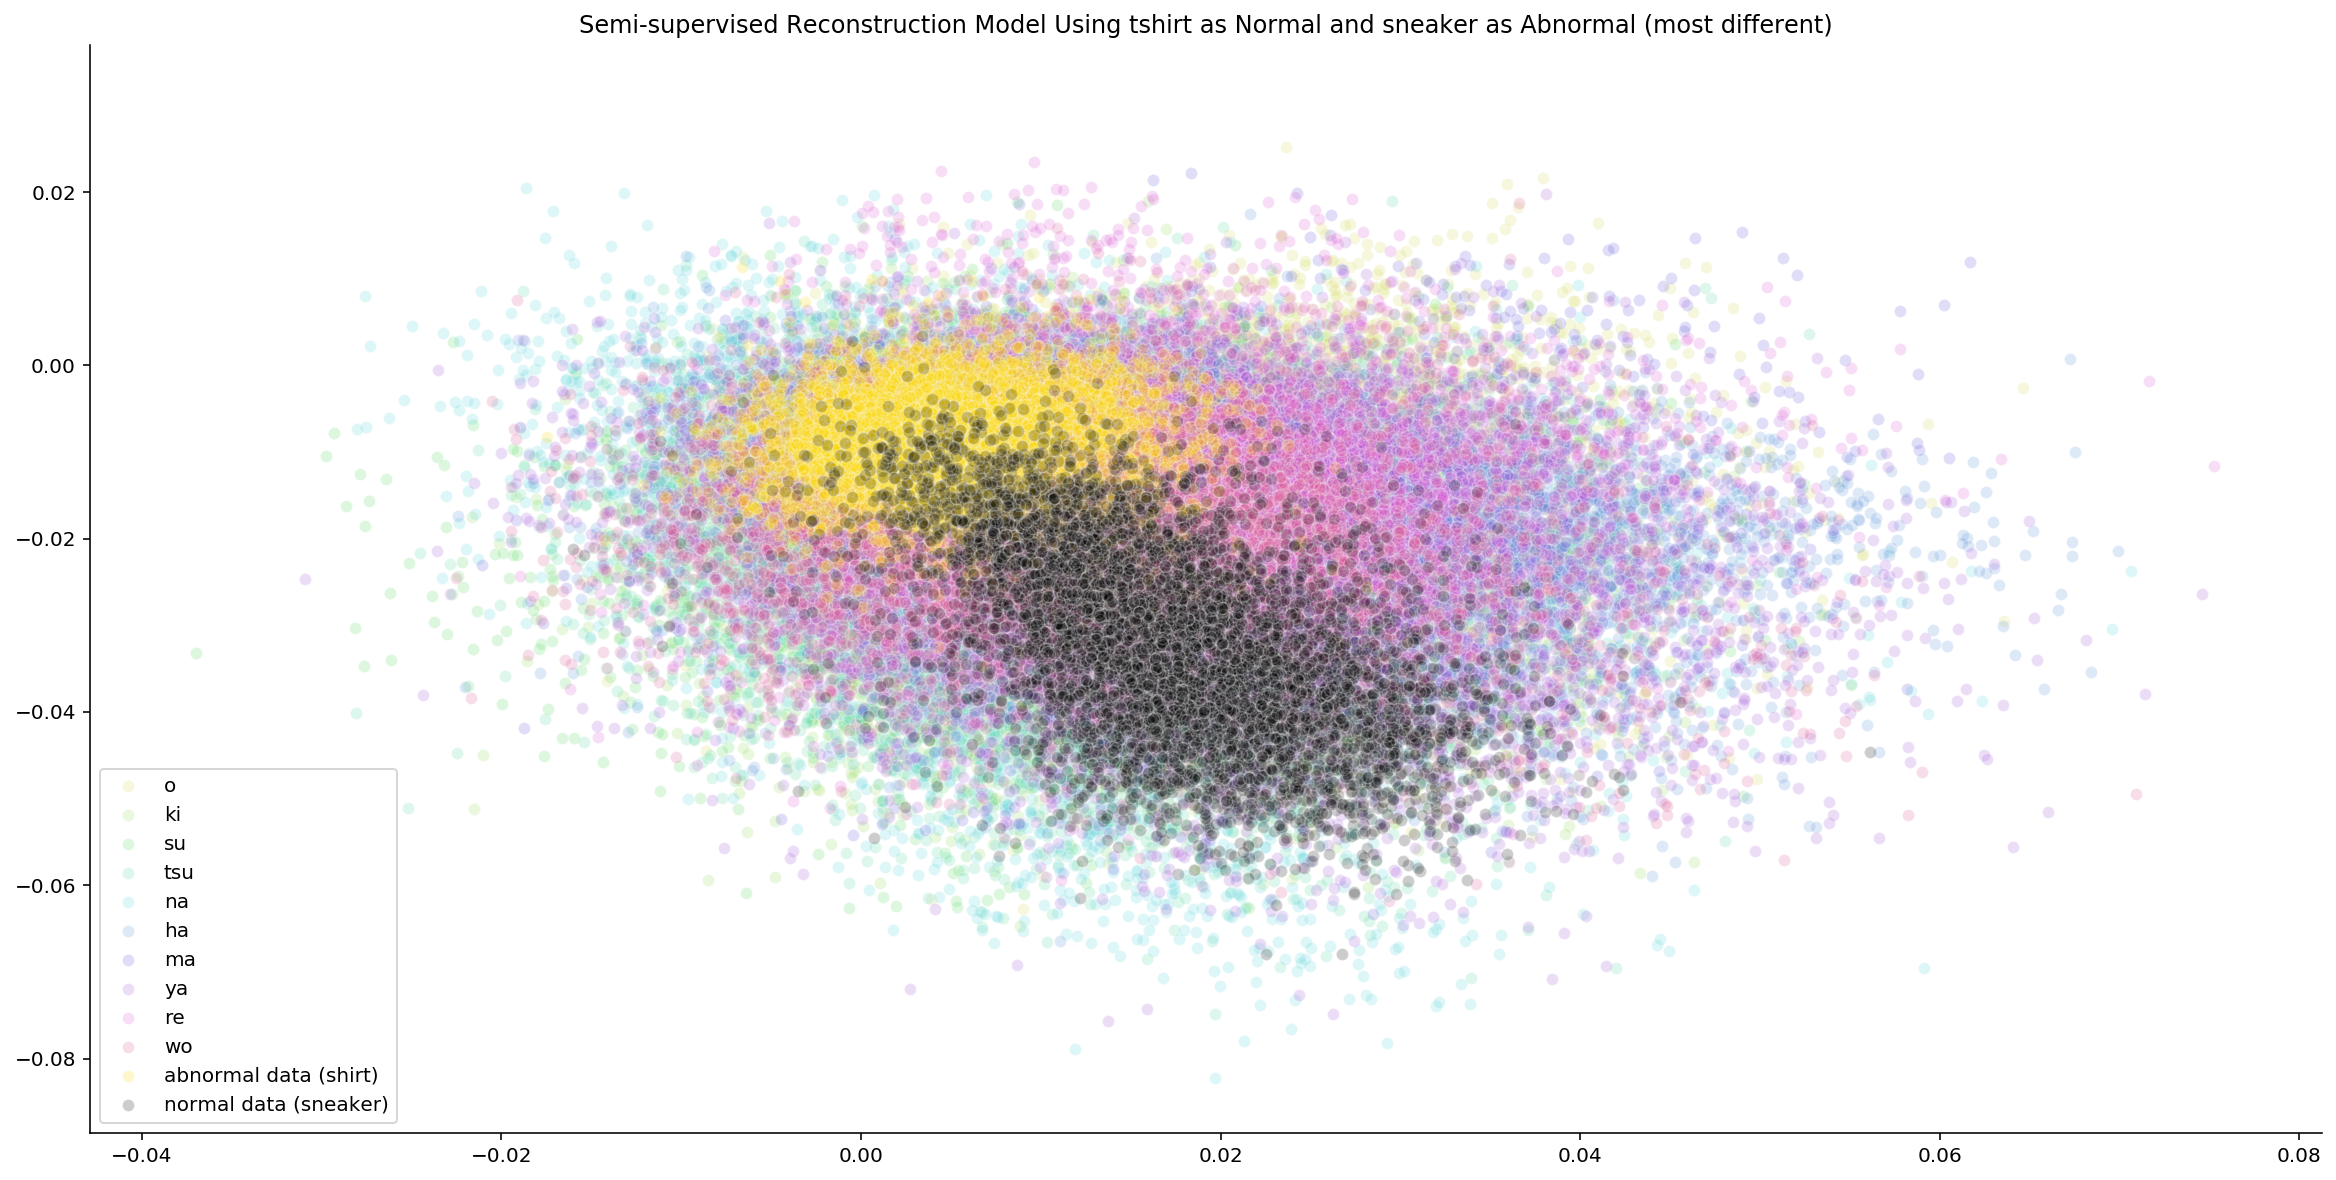

In [6]:
loader_eval_name = 'kmnist_eval'
root_eval = '/net/leksai/data/KMNIST'
label_eval_list = [(i,) for i in range(10)]
dataset_eval_list = []
for label_eval in label_eval_list:
    dataset_eval_list.append(load_dataset(loader_name=loader_eval_name,
                                          root=root_eval,
                                          label_eval=label_eval,
                                          test_eval=False))

data_list = []
for dataset_eval in dataset_eval_list:
    data = encoder.test(dataset_eval, device, batch_size, n_jobs_dataloader)
    data = np.array([x.cpu().numpy() for x in data])
    data_list.append(data.T)

normal_dataset = load_dataset(loader_name='fmnist_eval',
                                          root=root,
                                          label_eval=(0,),
                                          test_eval=False)
normal_data = encoder.test(normal_dataset, device, batch_size, n_jobs_dataloader)
normal_data = np.array([x.cpu().numpy() for x in normal_data]).T

abnormal_dataset = load_dataset(loader_name='fmnist_eval',
                                          root=root,
                                          label_eval=(7,),
                                          test_eval=False)
abnormal_data = encoder.test(abnormal_dataset, device, batch_size, n_jobs_dataloader)
abnormal_data = np.array([x.cpu().numpy() for x in abnormal_data]).T

num_to_letter = {0:'o', 1:'ki', 2:'su', 3:'tsu', 4:'na', 5:'ha', 6:'ma', 7:'ya', 8:'re', 9:'wo'}

letter_to_num = {v:k for k, v in num_to_letter.items()}

fig, ax = plt.subplots(figsize=(20, 10))

for letter in letter_to_num:
    label = letter_to_num[letter]
    data = data_list[label]
    cluster = sns.scatterplot(x=data[0], y=data[1], label=letter, alpha=0.2, color=sns.color_palette("hls", 12)[2:][label])

cluster = sns.scatterplot(x=abnormal_data[0], y=abnormal_data[1], label='abnormal data (shirt)', alpha=0.2, color='gold')
cluster = sns.scatterplot(x=normal_data[0], y=normal_data[1], label='normal data (sneaker)', alpha=0.2, color='black')

    
plt.legend()
plt.title('Semi-supervised Reconstruction Model Using tshirt as Normal and sneaker as Abnormal (most different)')
# plt.ylim(-0.04, 0.08)
# plt.xlim(-0.04, 0.10)
sns.despine()


In [14]:
label_eval_list = [(i,) for i in range(10)]
dataset_eval_list = []
for label_eval in label_eval_list:
    dataset_eval_list.append(load_dataset(loader_name=loader_eval_name,
                                          root=root,
                                          label_eval=label_eval,
                                          test_eval=False))

In [15]:
data_list = []
for dataset_eval in dataset_eval_list:
    data = encoder.test(dataset_eval, device, batch_size, n_jobs_dataloader)
    data = np.array([x.cpu().numpy() for x in data])
    data_list.append(data.T)

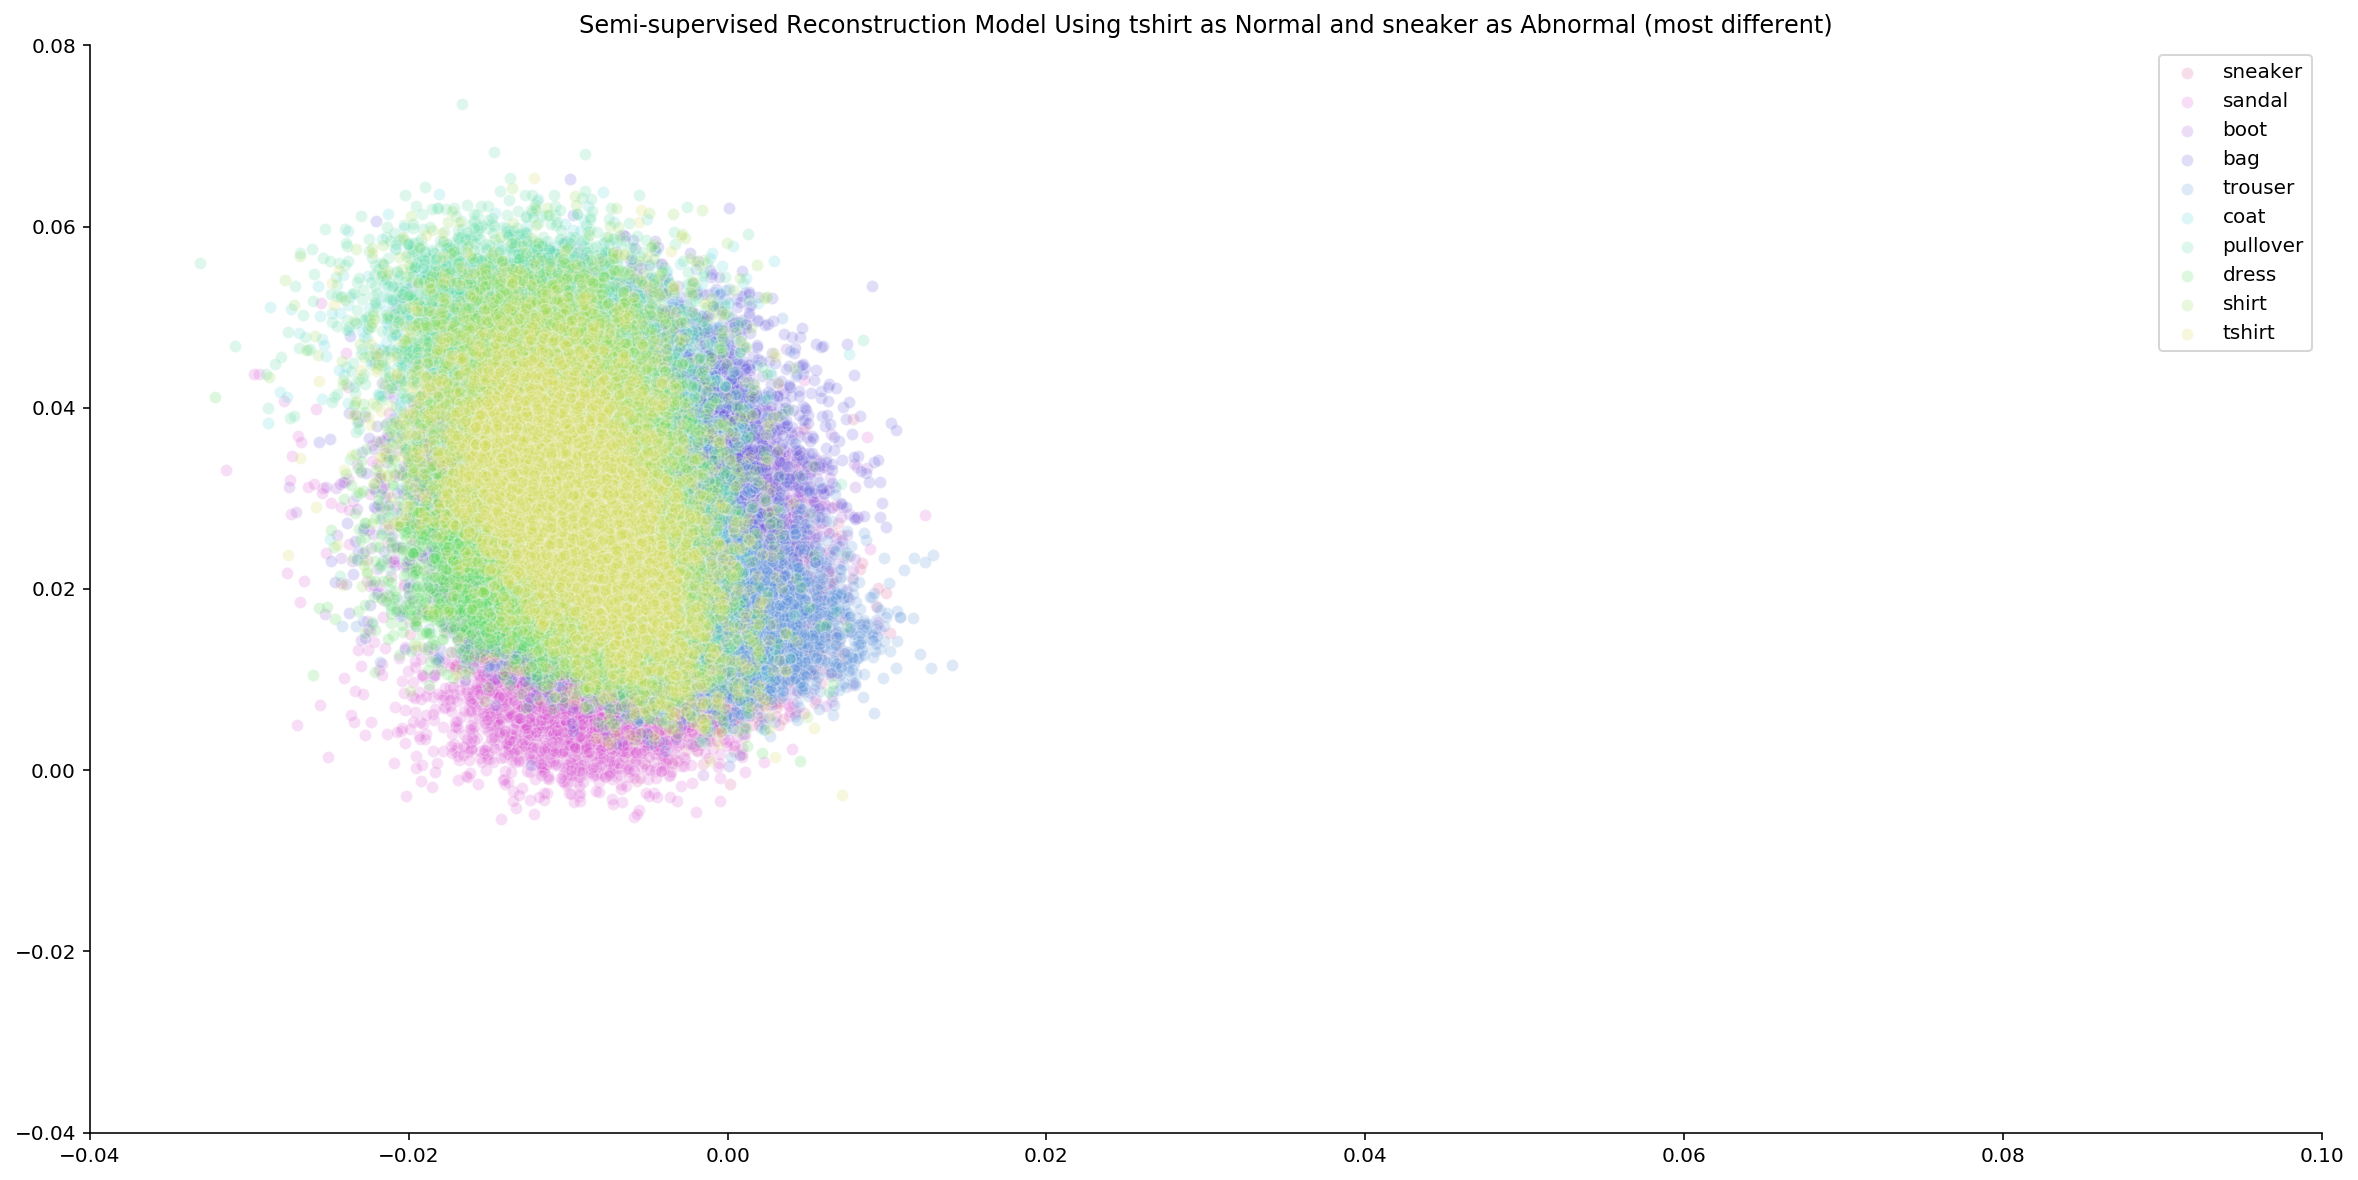

In [30]:
color_dict = {'tshirt':0,
              'shirt': 1,
              'dress':2,
              'pullover':3,
              'coat':4,
              'trouser':5,
               'bag': 6,
              'boot': 7,
              'sandal': 8,
              'sneaker':9}

num_to_letter ={0: 'tshirt', 
                1: 'trouser', 
                2: 'pullover', 
                3: 'dress', 
                4: 'coat',
                5: 'sandal', 
                6: 'shirt', 
                7: 'sneaker', 
                8: 'bag', 
                9: 'boot'}

letter_to_num = {v:k for k, v in num_to_letter.items()}

fig, ax = plt.subplots(figsize=(20, 10))

for letter in list(color_dict)[::-1]:
    label = letter_to_num[letter]
    data = data_list[label]
    cluster = sns.scatterplot(x=data[0], y=data[1], label=letter, alpha=0.2, color=sns.color_palette("hls", 12)[2:][color_dict[letter]])

plt.legend()
plt.title('Semi-supervised Reconstruction Model Using tshirt as Normal and sneaker as Abnormal (most different)')
plt.ylim(-0.04, 0.08)
plt.xlim(-0.04, 0.10)
sns.despine()
